In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
from typing import List, Tuple
from scipy.stats import skew, kurtosis

In [2]:
# Load the data
data = {
    "eod_balance_training": pd.read_csv(
        "../berkabank/primary/eod_balance_training.csv"
    ),
    "incidents": pd.read_csv("../berkabank/primary/incidents.csv"),
}

In [3]:
from dataclasses import dataclass
import pandas as pd
from typing import Dict, List, Any, Callable


@dataclass
class IncidentFeatures:
    incidents: pd.DataFrame
    column_mapping: dict

    def run(self):
        print("----- Running IncidentFeatures...")
        incident_features = pd.DataFrame()
        print("----- IncidentFeatures completed.")
        return incident_features


@dataclass
class EODBFeatures:
    eod_balance_training: pd.DataFrame
    column_mapping: dict
    aggregations: dict

    def run(self):
        print("----- Running EODBFeatures...")
        eodb_features_output = pd.DataFrame()
        print("----- EODBFeatures completed.")
        return eodb_features_output


@dataclass
class PrimaryFeatures:
    incident_features: IncidentFeatures
    eodb_features: EODBFeatures

    def __post_init__(self):
        print("--- Initializing PrimaryFeatures...")
        self.incident_features_output = self.incident_features.run()
        self.eodb_features_output = self.eodb_features.run()
        print("--- PrimaryFeatures initialized.")

    def run(self):
        print("--- Running PrimaryFeatures...")
        primary_features_output = pd.DataFrame()
        print("--- PrimaryFeatures completed.")
        return primary_features_output


@dataclass
class DerivedFeatures:
    primary_features: PrimaryFeatures

    def __post_init__(self):
        print("--- Initializing DerivedFeatures...")
        self.primary_features_output = self.primary_features.run()
        print("--- DerivedFeatures initialized.")

    def run(self):
        print("--- Running DerivedFeatures...")
        derived_features = pd.DataFrame()
        print("--- DerivedFeatures completed.")
        return derived_features


@dataclass
class FeatureEngineering:
    primary_features: PrimaryFeatures
    derived_features: DerivedFeatures

    def run(self):
        print("Running FeatureEngineering...")
        self.derived_features.run()
        print("FeatureEngineering completed.")

In [4]:
column_mapping = {
    "incidents": {
        "account_id": "account_id",
        "incident_date": "incident_date",
        "district_id": "district_id",
        "t0": "t0",
        "t1": "t1",
    },
    "eod_balance_training": {
        "account_id": "account_id",
        "balance_date": "balance_date",
        "end_of_day_balance": "end_of_day_balance",
        "daily_amount_flow": "daily_amount_flow",
        "n_transactions": "n_transactions",
        "days_since_account_creation": "days_since_account_creation",
        "low_balance_streak": "low_balance_streak",
        "district_id": "district_id",
    },
}

In [5]:
df = (
    data["eod_balance_training"]
    .loc[
        :,
        [
            "account_id",
            "balance_date",
            "end_of_day_balance",
            "daily_amount_flow",
            "n_transactions",
        ],
    ]
    .copy()
)

In [6]:
df.head()

,account_id,balance_date,end_of_day_balance,daily_amount_flow,n_transactions
0,576,1993-01-11,7107.0,6207.0,1.0
1,576,1993-01-12,7107.0,0.0,1.0
2,576,1993-01-13,7107.0,0.0,1.0
3,576,1993-01-14,7107.0,0.0,1.0
4,576,1993-01-15,7107.0,0.0,1.0


In [7]:
df["flow_category"] = (
    df["daily_amount_flow"].gt(0).replace({True: "inflow", False: "outflow"})
)
df["daily_amount_inflow"] = df["daily_amount_flow"].clip(lower=0)
df["daily_amount_outflow"] = df["daily_amount_flow"].clip(upper=0).abs()

In [8]:
import pandas as pd
import re


def percentile(p):
    def percentile_(x):
        return np.nanpercentile(x, p)

    percentile_.__name__ = "percentile_%s" % p
    return percentile_


def kurtosis(series):
    return pd.Series(series).kurt()


def get_function_name(func):
    if callable(func):
        return func.__name__
    else:
        return func


def create_aggregations(
    max_t: int = 60,
    min_t: int = 5,
    step: int = 5,
    agg_funcs: List[str] = ["mean", "max", "sum", "std", "median"],
    features: List[str] = ["daily_amount_flow", "n_transactions"],
) -> List[str]:
    """Create aggregation names based on the given parameters.

    Args:
        max_t (int, optional): Maximum time period. Defaults to 60.
        min_t (int, optional): Minimum time period. Defaults to 5.
        agg_funcs (List[str], optional): Aggregation functions. Defaults to ["mean", "max", "sum", "std", "median"].
        category (List[str], optional): Categories. Defaults to ["inflow", "outflow"].
        features (List[str], optional): Features. Defaults to ["daily_amount_flow"].

    Returns:
        List[str]: Names of the aggregations.
    """
    return [
        f"f_{feature}__rolling_{get_function_name(func)}_{time_period}_days"
        for feature in features
        for time_period in range(min_t, max_t + 1, step)
        for func in agg_funcs
    ]


def parse_aggregation(aggregation):
    """Parse the name of an aggregation to get the feature, category, function, and time period.

    Args:
        aggregation (str): Name of the aggregation.

    Returns:
        tuple: feature, category, function, time period.
    """
    match = re.match(r"f_(\w+)__rolling_(\w+)_(\d+)_days", aggregation)
    feature, func, time_period = match.groups()
    time_period = int(time_period)

    return feature, func, time_period

In [38]:
aggregation_list = [
    "mean",
    "min",
    "max",
    "sum",
    "std",
    "median",
    "skew",
    "kurtosis",
] + [f"percentile_{p}" for p in range(10, 100, 25)]

aggregations = create_aggregations(
    max_t=90,
    min_t=10,
    step=10,
    agg_funcs=aggregation_list,
    features=["daily_amount_inflow", "daily_amount_outflow", "n_transactions"],
)

In [39]:
import warnings


def make_aggregations(
    df: pd.DataFrame,
    agg_funcs: List[str],
    aggregation_mapping: Dict[str, str] = None,
    index: str = "account_id",
) -> pd.DataFrame:
    """Create rolling aggregations for the given dataframe based on the name of the aggregation.

    Args:
        df (pd.DataFrame): DataFrame containing eos balance data.
        agg_funcs (List[str]): Feature names to create rolling aggregations for.

    Returns:
        pd.DataFrame: DataFrame with rolling aggregations for each period.
    """
    if aggregation_mapping is None:
        aggregation_mapping = {
            "mean": "mean",
            "min": "min",
            "max": "max",
            "sum": "sum",
            "std": "std",
            "median": "median",
            "skew": "skew",
            "kurtosis": "kurt",
            **{f"percentile_{p}": "quantile" for p in range(5, 100)},
        }

    for aggregation in agg_funcs:
        print(f"Applying aggregation function: {aggregation}")
        feature, func, time_period = parse_aggregation(aggregation)
        agg = aggregation_mapping.get(func)
        if agg is None:
            raise ValueError(f"Function {func} not found in the function mapping.")

        params = {}
        if func.startswith("percentile"):

            percentile = int(func.split("_")[1]) / 100
            params[agg] = percentile
        # Suppress the FutureWarning
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            df[aggregation] = getattr(
                df.groupby(index)[feature].rolling(time_period), agg
            )(**params).reset_index(level=0, drop=True)

    return df

In [ ]:
df_agg = (
    make_aggregations(df, aggregations)
    .groupby("account_id")[aggregations]
    .agg(
        [
            "sum",
            "size",
            "mean",
            "std",
            "min",
            "max",
            "skew",
        ]
    )
)



In [41]:
df_agg.columns = [f"f_{col[0]}_{col[1]}" for col in df_agg.columns.values]

In [62]:
df_agg.f_f_daily_amount_inflow__rolling_mean_10_days_sum.kurt()

3.2352190784655637

In [43]:
def drop_missing_percentage(df, threshold=0.1):
    """
    Returns a list of column names from the DataFrame where less than 10% of the data is missing.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.

    Returns:
    list: A list of column names.
    """
    columns = (
        (df.isna().mean() < threshold)
        .replace({True: 1, False: np.nan})
        .dropna()
        .index.to_list()
    )
    return df.loc[:, columns]

In [71]:
@dataclass
class FeatureEliminationMissingRate:
    """Feature elimination class.

    Attributes:
        missing_rate_threshold (float): missing rate threshold

    Methods:
        run(X, y): fit the model

    Returns:
        list: reduced feature set
    """

    missing_rate_threshold: float

    def run(self, X: pd.DataFrame) -> pd.DataFrame:
        """Run the feature elimination process.

        Args:
            X (pd.DataFrame): input features
            y (np.array): target variable

        Returns:
            list: reduced feature set
        """
        missing_rate = X.isnull().mean()
        features_to_keep = missing_rate[
            missing_rate < self.missing_rate_threshold
        ].index
        return X[features_to_keep]




@dataclass
class FeatureEliminationKurtosis:
    """Feature elimination class.

    Attributes:
        kurtosis_threshold (float): kurtosis threshold

    Methods:
        run(X, y): fit the model

    Returns:
        list: reduced feature set
    """

    kurtosis_threshold: float

    def run(self, X: pd.DataFrame) -> pd.DataFrame:
        """Run the feature elimination process.

        Args:
            X (pd.DataFrame): input features

        Returns:
            list: reduced feature set
        """
        kurt = X.apply(kurtosis)
        features_to_keep = kurt[kurt < self.kurtosis_threshold].index
        return X[features_to_keep]
    


@dataclass
class FeatureEliminationCoV:
    """Feature elimination class.

    Attributes:
        cov_threshold (float): coefficient of variation threshold

    Methods:
        run(X, y): fit the model

    Returns:
        list: reduced feature set
    """

    cov_threshold: float

    def run(self, X: pd.DataFrame) -> pd.DataFrame:
        """Run the feature elimination process.

        Args:
            X (pd.DataFrame): input features
            y (np.array): target variable

        Returns:
            list: reduced feature set
        """
        cov = X.std() / X.mean()
        features_to_keep = cov[cov > self.cov_threshold].index
        return X[features_to_keep]



@dataclass
class FeatureEliminationVIF:
    """Feature elimination class.

    Attributes:
        vif_threshold (float): VIF threshold

    Methods:
        run(X): fit the model

    Returns:
        DataFrame: reduced feature set
    """

    vif_threshold: float
    filler: float = -1

    def run(self, X: pd.DataFrame) -> pd.DataFrame:
        """Run the feature elimination process.

        Args:
            X (pd.DataFrame): input features

        Returns:
            DataFrame: reduced feature set
        """
        # Calculate VIF
        vif = pd.DataFrame()
        vif["variables"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.fillna(self.filler).values, i) for i in range(X.shape[1])]

        # Select variables below the threshold
        features_to_keep = vif[vif["VIF"] < self.vif_threshold]["variables"]

        return X[features_to_keep]

@dataclass
class FeatureEliminationPipeline:
    steps: Dict[str, Any]

    def run(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        """Run the feature elimination process.

        Args:
            X (pd.DataFrame): input features
            y (np.array): target variable

        Returns:
            list: reduced feature set
        """
        for step in self.steps:
            if y is None:
                X = self.steps[step].run(X)
            else:
                X = self.steps[step].run(X, y)
        return X


feature_elimination_pipeline = FeatureEliminationPipeline(
    {
        "missing_rate": FeatureEliminationMissingRate(0.1),
        "cov": FeatureEliminationCoV(0.8),
        "kurtosis": FeatureEliminationKurtosis(3),
        "vif": FeatureEliminationVIF(10),

    }
)

df_agg_fel = feature_elimination_pipeline.run(df_agg, y=None)

/Users/davidelupis/Desktop/Testing/berkabank/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [72]:
df_agg_fel.fillna(-1)

,f_f_daily_amount_inflow__rolling_percentile_85_10_days_skew,f_f_daily_amount_inflow__rolling_skew_20_days_min,f_f_daily_amount_inflow__rolling_kurtosis_30_days_min,f_f_daily_amount_outflow__rolling_median_10_days_skew,f_f_daily_amount_outflow__rolling_percentile_60_10_days_skew,f_f_daily_amount_outflow__rolling_skew_20_days_min,f_f_daily_amount_outflow__rolling_percentile_60_20_days_skew,f_f_daily_amount_outflow__rolling_percentile_85_40_days_skew,f_f_daily_amount_outflow__rolling_percentile_85_80_days_skew,f_f_n_transactions__rolling_std_10_days_skew,f_f_n_transactions__rolling_skew_20_days_sum,f_f_n_transactions__rolling_kurtosis_20_days_sum,f_f_n_transactions__rolling_kurtosis_30_days_max,f_f_n_transactions__rolling_skew_50_days_skew
account_id,,,,,,,,,,,,,,
1,10.788792,3.278878,16.930959,12.020386,11.116302,0.000000,0.000000,9.102860,8.395925,0.873774,26.721235,-172.595728,0.790099,1.402900
2,13.783764,0.000000,16.373964,0.000000,9.669138,1.830236,0.000000,4.664997,6.403709,-0.057779,4.926799,-289.918538,-0.043243,0.023308
4,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,4.329126,0.000000,0.280326,18.398237,28.912325,30.000012,1.323397
6,0.000000,0.000000,29.958443,9.418377,6.952959,1.463399,8.368098,2.959221,3.433695,0.117853,11.988076,92.175391,0.981849,0.091589
9,6.717659,3.183828,15.819220,0.000000,13.472984,0.000000,0.000000,8.691431,17.233688,0.656707,30.417814,-136.377951,6.940640,-0.195206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11320,1.391811,0.000000,12.206633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147983,-17.978819,228.074982,3.887472,0.366872
11333,5.267280,0.000000,-3.000000,9.556136,7.583096,0.000000,13.704262,4.963759,0.000000,0.640598,44.197975,413.441887,14.572999,-0.557728
11349,0.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.236068,0.000000,0.000000,-1.000000,-1.000000


In [78]:
core = pd.read_csv("../berkabank/primary/core.csv")


,account_id,target
0,576,True
1,3818,False
2,704,False
3,2378,False
4,2632,True
...,...,...
2144,2475,False
2145,4949,False
2146,5317,False
2147,4375,False


In [83]:
model_matrix = df_agg_fel.reset_index().merge(core, on="account_id", how="inner").set_index("account_id")

,f_f_daily_amount_inflow__rolling_percentile_85_10_days_skew,f_f_daily_amount_inflow__rolling_skew_20_days_min,f_f_daily_amount_inflow__rolling_kurtosis_30_days_min,f_f_daily_amount_outflow__rolling_median_10_days_skew,f_f_daily_amount_outflow__rolling_percentile_60_10_days_skew,f_f_daily_amount_outflow__rolling_skew_20_days_min,f_f_daily_amount_outflow__rolling_percentile_60_20_days_skew,f_f_daily_amount_outflow__rolling_percentile_85_40_days_skew,f_f_daily_amount_outflow__rolling_percentile_85_80_days_skew,f_f_n_transactions__rolling_std_10_days_skew,f_f_n_transactions__rolling_skew_20_days_sum,f_f_n_transactions__rolling_kurtosis_20_days_sum,f_f_n_transactions__rolling_kurtosis_30_days_max,f_f_n_transactions__rolling_skew_50_days_skew
account_id,,,,,,,,,,,,,,
1,10.788792,3.278878,16.930959,12.020386,11.116302,0.000000,0.000000,9.102860,8.395925,0.873774,26.721235,-172.595728,0.790099,1.402900
2,13.783764,0.000000,16.373964,0.000000,9.669138,1.830236,0.000000,4.664997,6.403709,-0.057779,4.926799,-289.918538,-0.043243,0.023308
4,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,4.329126,0.000000,0.280326,18.398237,28.912325,30.000012,1.323397
6,0.000000,0.000000,29.958443,9.418377,6.952959,1.463399,8.368098,2.959221,3.433695,0.117853,11.988076,92.175391,0.981849,0.091589
9,6.717659,3.183828,15.819220,0.000000,13.472984,0.000000,0.000000,8.691431,17.233688,0.656707,30.417814,-136.377951,6.940640,-0.195206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11320,1.391811,0.000000,12.206633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147983,-17.978819,228.074982,3.887472,0.366872
11333,5.267280,0.000000,-3.000000,9.556136,7.583096,0.000000,13.704262,4.963759,0.000000,0.640598,44.197975,413.441887,14.572999,-0.557728
11349,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,2.236068,0.000000,0.000000,NaN,NaN


In [88]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import json
import numpy as np
from google.cloud import storage
import joblib

# Split train and validation
X = model_matrix.drop(["target"], axis=1)
y = model_matrix["target"]

# Balance cv and validation folds
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Pick the Model Estimator #TODO: serialize in input
estimator = RandomForestClassifier()


estimator.fit(X_train, y_train)
y_scores = estimator.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"TEST ROC AUC: {roc_auc}")
print(f"Optimal threshold: {optimal_threshold}")

TEST ROC AUC: 0.8211111111111111
Optimal threshold: 0.44


<Axes: >

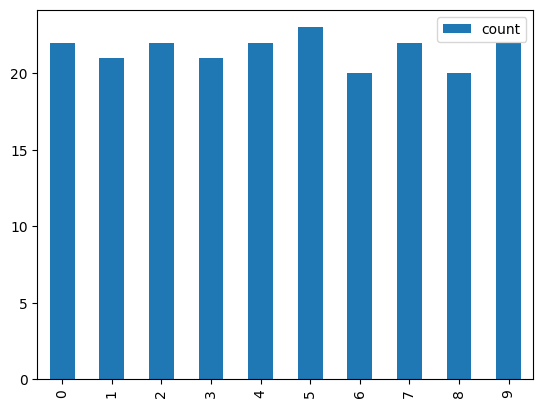

In [112]:
pd.DataFrame(pd.qcut(pd.Series(y_scores),10, labels=False).value_counts().sort_index()).plot(kind='bar')